# Annotation Metadata Review Strategy

## Overview

This notebook provides an interactive analysis of annotation metadata across DCC data models.

## For DCC Data (Primary Importance)

Annotation metadata in Synapse feed the DCC portals and are viewable to users in Synapse when browsing through projects they can see. Annotations are viewable by anonymous users for any data made public ("globe" icon) in Synapse, *even* controlled-access data (Figure 1). Given that annotations are exposed to third parties for improved findability when data is made public, **annotations should indeed be low-risk, non-sensitive information** suitable for the public domain. Formerly, the concept of third parties might include Google crawlers, but we are now facilitating annotation access to AI agents via MCP. AI exposure motivate another level of review especially for DCC data where Sage is most responsible, to confirm that **DCC-managed data** have annotations allowable for consumption.

DCCs currently manage data with strong standards, and we currently depend on annotation safeguard through their operations. For DCCs, annotations are submitted to Synapse only after validation and potential data transformation (masking) through a curation application (DCA) that enforces the allowed attributes, values, and transformation rules defined in the maintained data model. These operations work per "template". An "Annotation Template" defines what **annotations (keys and values)** are placed on an Synapse entity such as a project, dataset, folder, file, etc. Another type of "Record Template" defines the **internal content and format (columns, values)** of a CSV file or a table uploaded to Synapse. This is an important distinction. Operationally, sensitive data/metadata must be submitted as a CSV file or Synapse table, so that AR can be applied on these entities (ARs cannot be applied on annotations). The DCC specifies this by using the "record" configuration for the appropriate template in the standard curation application (DCA) so that during curation workflow, values are submitted into a file or table (Figure 2). **This means that, theoretically, no sensitive data end up as annotations, as long as the DCCs has defined their data model judiciously and the configuration correctly.** Because the Synapse MCP currently does not enable any functionality with "download" scope, AI agents will not be able to pull any CSV file or Synapse table content (this requires *download* scope).

We do an analysis of all DCC Annotation Templates, since values submitted from these templates are transferred to Synapse as annotations. For all Annotation Templates, we can classify the present attributes, permissible values/range, and data transformation rules to judge how much of a risk the metadata would be as an annotation. If it is too sensitive, it should not be in the annotation pipeline.

## Setup and Data Loading

In [2]:
# Import required libraries
from rdflib import Graph, Namespace
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load RDF graph with data models and enrichment data
def load_graph():
    """Load both data model and enrichment RDF graphs."""
    g = Graph()
    
    # Load data models
    print("Loading data model TTL files...")
    for f in sorted(Path('data_models_rdf').glob('*.ttl')):
        g.parse(f, format='turtle')
        print(f"  ✓ {f.name}")
    
    # Load enrichment
    print("\nLoading enrichment TTL files...")
    for f in sorted(Path('template_enrichment_rdf').glob('*.ttl')):
        g.parse(f, format='turtle')
        print(f"  ✓ {f.name}")
    
    print(f"\n📊 Total graph: {len(g):,} triples loaded\n")
    return g

# Load the graph
graph = load_graph()

Loading data model TTL files...
  ✓ ADKP_data_model.ttl
  ✓ AMP-AIM_data_model.ttl
  ✓ BTC_data_model.ttl
  ✓ CB_data_model.ttl
  ✓ EL_data_model.ttl
  ✓ GF_data_model.ttl
  ✓ HTAN2_data_model.ttl
  ✓ HTAN_data_model.ttl
  ✓ MC2_data_model.ttl
  ✓ NF-OSI_data_model.ttl
  ✓ VEOIBD_data_model.ttl

Loading enrichment TTL files...
  ✓ ADKP_enrichment.ttl
  ✓ AMP-AIM_enrichment.ttl
  ✓ BTC_enrichment.ttl
  ✓ CB_enrichment.ttl
  ✓ EL_enrichment.ttl
  ✓ GF_enrichment.ttl
  ✓ HTAN2_enrichment.ttl
  ✓ HTAN_enrichment.ttl
  ✓ MC2_enrichment.ttl
  ✓ NF-OSI_enrichment.ttl
  ✓ VEOIBD_enrichment.ttl

📊 Total graph: 283,773 triples loaded



## Template Distribution Analysis

The table below summarizes the templates across the latest DCC data models in GitHub. A template can be configured as:
- **Record Template**: Defines internal content/format of CSV files or Synapse tables (sensitive data)
- **Annotation Template** (Metadata): Defines annotations (keys/values) for entities (usually for files, sometimes for folders or dataset entities)
- **Unconfigured**: Not surfaced in curation workflow (draft or abstract templates)

In [4]:
# Query template distribution by project and type
query = """
PREFIX dca: <https://dca.app.sagebionetworks.org/vocab/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?project ?templateType (COUNT(?template) as ?templateCount)
WHERE {
  ?template a ?templateType .
  FILTER(?templateType IN (dca:AnnotationTemplate, dca:RecordTemplate, dca:UnconfiguredTemplate))
  
  # Extract project from URI
  BIND(REPLACE(STR(?template), "https://dca.app.sagebionetworks.org/([^/]+)/.*", "$1") AS ?project)
}
GROUP BY ?project ?templateType
ORDER BY ?project ?templateType
"""

results = graph.query(query)

# Convert to pandas DataFrame
data = []
for row in results:
    template_type = str(row.templateType).split('/')[-1]
    data.append({
        'Project': str(row.project),
        'Type': template_type,
        'Count': int(row.templateCount)
    })

df = pd.DataFrame(data)

# Pivot to create summary table
pivot_df = df.pivot(index='Project', columns='Type', values='Count').fillna(0).astype(int)

# Rename columns for clarity
column_map = {
    'AnnotationTemplate': 'Annotation',
    'RecordTemplate': 'Record',
    'UnconfiguredTemplate': 'Unconfigured'
}
pivot_df = pivot_df.rename(columns=column_map)

# Ensure all columns exist
for col in ['Annotation', 'Record', 'Unconfigured']:
    if col not in pivot_df.columns:
        pivot_df[col] = 0

# Reorder columns
pivot_df = pivot_df[['Annotation', 'Record', 'Unconfigured']]

# Add total column
pivot_df['Total'] = pivot_df.sum(axis=1)

# Reorder to match original table
pivot_df = pivot_df[['Total', 'Annotation', 'Record', 'Unconfigured']]

# Add Grand Total row
grand_total = pivot_df.sum()
grand_total.name = 'Grand Total'
pivot_df = pd.concat([pivot_df, grand_total.to_frame().T])

# Display the table
print("\n📊 Template Distribution by Project and Type\n")
display(pivot_df)


📊 Template Distribution by Project and Type



Type,Total,Annotation,Record,Unconfigured
ADKP,32,1,28,3
AMP-AIM,20,2,1,17
BTC,8,1,0,7
CB,2,0,0,2
EL,17,11,4,2
GF,40,7,1,32
HTAN,135,62,27,46
HTAN2,136,63,28,45
MC2,37,1,11,25
NF-OSI,49,23,1,25


### Interpretation

To give a better comparison for the above table:
- **ADKP** is conservative in that all metadata are represented as files, even technical assay metadata that are normally considered low risk. There are only two Annotation Templates. One for adding annotation metadata about data file entities, and the other for adding annotation metadata about analysis file entities.
- On the other end of the spectrum, **NF-OSI** has mostly file Annotation Templates and only one Record Template.

### Example Annotation Templates by DCC

Let's look at one example Annotation Template from each DCC to understand what they're used for.

In [5]:
# Query for one example Annotation Template from each DCC
example_query = """
PREFIX dca: <https://dca.app.sagebionetworks.org/vocab/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?project ?template ?templateName ?description
WHERE {
  ?template a dca:AnnotationTemplate .
  
  # Extract project from URI
  BIND(REPLACE(STR(?template), "https://dca.app.sagebionetworks.org/([^/]+)/.*", "$1") AS ?project)
  
  # Get template name and description
  OPTIONAL { ?template rdfs:label ?label }
  OPTIONAL { ?template rdfs:comment ?description }
  
  # Extract template name (use label if available, otherwise URI fragment)
  BIND(IF(BOUND(?label), ?label, 
     REPLACE(STR(?template), ".*[/#]([^/#]+)$", "$1")) AS ?templateName)
}
ORDER BY ?project ?template
"""

example_results = list(graph.query(example_query))

# Get one example per project
seen_projects = set()
example_data = []

for row in example_results:
    project = str(row.project)
    if project not in seen_projects:
        seen_projects.add(project)
        example_data.append({
            'Project': project,
            'Template Name': str(row.templateName),
            'Description': str(row.description) if row.description else 'N/A'
        })

example_df = pd.DataFrame(example_data)

print("\n📋 Example Annotation Template from Each DCC\n")
display(example_df)


📋 Example Annotation Template from Each DCC



,Project,Template Name,Description
0,ADKP,FileAnnotationTemplate,AD file annotation template schema
1,AMP-AIM,CyTOFSDPAnnotationTemplate,A component for collecting file-level metadata...
2,BTC,BulkRNA-seqLevel1,Bulk RNA-seq [EFO_0003738]
3,EL,AssayBsSeqTemplate,Template for bsSeq
4,GF,ImagingLevel2,TBD
5,HTAN,10XGenomicsXeniumISSExperiment,All data pertaining to the 10X Genomics Xenium...
6,HTAN2,10XGenomicsXeniumISSExperiment,All data pertaining to the 10X Genomics Xenium...
7,MC2,FileView,The denormalized manifest for file submission.
8,NF-OSI,BehavioralAssayTemplate,Template for behavioral assay data from model ...


### Viz: Template Distribution

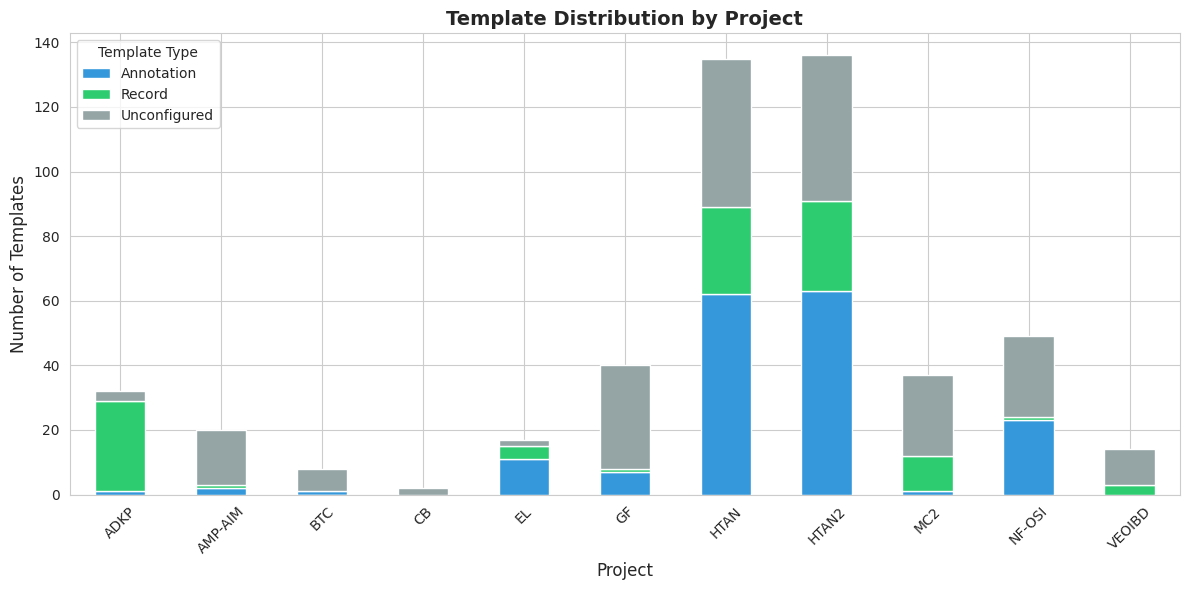

In [6]:
# Create stacked bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Remove Grand Total for visualization
plot_df = pivot_df.iloc[:-1]

# Stacked bar chart
plot_df[['Annotation', 'Record', 'Unconfigured']].plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=['#3498db', '#2ecc71', '#95a5a6']
)
ax.set_title('Template Distribution by Project', fontsize=14, fontweight='bold')
ax.set_xlabel('Project', fontsize=12)
ax.set_ylabel('Number of Templates', fontsize=12)
ax.legend(title='Template Type', loc='upper left')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Attribute-Level Analysis

Let's look at the actual attributes used in Annotation Templates to understand what metadata is exposed.

In [7]:
# Visualize attribute distribution
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# # Histogram of attribute counts
# annotation_df['Attribute Count'].hist(bins=20, ax=ax, color='#3498db', edgecolor='black')
# ax.set_title('Distribution of Attribute Counts in Annotation Templates', fontsize=14, fontweight='bold')
# ax.set_xlabel('Number of Attributes', fontsize=12)
# ax.set_ylabel('Number of Templates', fontsize=12)
# ax.axvline(annotation_df['Attribute Count'].mean(), color='red', linestyle='--', label=f"Mean: {annotation_df['Attribute Count'].mean():.1f}")
# ax.legend()

# plt.tight_layout()
# plt.show()

### Attribute Examples/Overview

For context, below are sampled annotation attributes.

In [8]:
# Query for all attributes in Annotation Templates
attribute_query = """
PREFIX dca: <https://dca.app.sagebionetworks.org/vocab/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>

SELECT DISTINCT ?attribute ?label ?description ?project
WHERE {
  ?template a dca:AnnotationTemplate .
  ?template dca:requiresDependency ?attribute .
  
  ?attribute rdfs:label ?label .
  OPTIONAL { ?attribute rdfs:comment ?description }
  
  # Extract project
  BIND(REPLACE(STR(?template), "https://dca.app.sagebionetworks.org/([^/]+)/.*", "$1") AS ?project)
}
ORDER BY ?label
"""

attribute_results = graph.query(attribute_query)

# Convert to DataFrame
attr_data = []
for row in attribute_results:
    attr_data.append({
        'Attribute': str(row.label),
        'Description': str(row.description) if row.description else 'N/A',
        'Project': str(row.project),
        'URI': str(row.attribute)
    })

attr_df = pd.DataFrame(attr_data)

print(f"\n📋 Found {len(attr_df)} unique attributes across Annotation Templates\n")
print("Sample attributes:")
display(attr_df.head(20))

# Count attribute usage across projects
attr_counts = attr_df['Attribute'].value_counts()
print(f"\n🔄 Attribute Reuse:")
print(f"  Attributes used in multiple projects: {(attr_counts > 1).sum()}")
print(f"  Most commonly used attribute: '{attr_counts.index[0]}' ({attr_counts.iloc[0]} projects)")


📋 Found 1322 unique attributes across Annotation Templates

Sample attributes:


,Attribute,Description,Project,URI
0,AbNameReportedonDataset,The antibody name.,HTAN2,https://dca.app.sagebionetworks.org/HTAN2/AbNa...
1,AbNameReportedonDataset,The antibody name.,HTAN,https://dca.app.sagebionetworks.org/HTAN/AbNam...
2,AccessReqs,TBD,EL,https://dca.app.sagebionetworks.org/EL/AccessReqs
3,AckContext,TBD,EL,https://dca.app.sagebionetworks.org/EL/AckContext
4,Acknowledgment,TBD,EL,https://dca.app.sagebionetworks.org/EL/Acknowl...
5,AcquisitionBatchID,"Acquisition batch identifier, provided by the ...",EL,https://dca.app.sagebionetworks.org/EL/Acquisi...
6,AcquisitionBatchSize,The number of samples,EL,https://dca.app.sagebionetworks.org/EL/Acquisi...
7,AcquisitionBatchSizeUnit,The unit of measurement for number of samples ...,EL,https://dca.app.sagebionetworks.org/EL/Acquisi...
8,AcquisitionMode,The specific aspect of a mass spectrometer met...,EL,https://dca.app.sagebionetworks.org/EL/Acquisi...
9,AcquisitionSoftware,The name of the acquisition software used. Pro...,EL,https://dca.app.sagebionetworks.org/EL/Acquisi...



🔄 Attribute Reuse:
  Attributes used in multiple projects: 431
  Most commonly used attribute: 'Component' (9 projects)


### Attribute assessment methodology

Each annotation attribute is reviewed through an external batch classification so downstream stakeholders can read a consistent risk report.

- **Prompt** (exact text):

```
You are a data privacy analyst tasked with classifying metadata attributes by sensitivity.
Classifications:
- High: Direct identifiers or information revealing personal identity, contact, precise location, financial, or highly sensitive clinical/behavioral data.
- Moderate: Quasi-identifiers (e.g., demographics, longitudinal visit markers, cohort identifiers), biospecimen or individual IDs that, while expected to be anonymized, could still aid re-identification, or sensitive contextual metadata.
- Low: Non-personal technical metadata (e.g., file properties, instrument settings) or general study logistics.
- NeedsReview: Insufficient information (descriptions like TBD/unknown) or unclear scope.
Enum values and validation rules may encode masking or constraint logic—review them carefully alongside descriptions before deciding. Choose exactly one class and provide a concise rationale referencing the attribute details.
```

- **Framework**: four-tier scale—High (direct identifiers), Moderate (quasi-identifiers or sensitive context, including anonymized individual/specimen IDs), Low (technical or logistical metadata), NeedsReview (insufficient detail such as TBD fields).
- **Model**: `gpt-5-mini-2025-08-07`, chosen for higher-quality judgments while keeping batch latency manageable.
- **Execution**: attribute records become `/v1/chat/completions` batch requests with a JSON schema `response_format` so the model returns a strict `{attribute_id, project, risk, rationale}` object per row; monitor the Batch API job and download its output once complete.




### Attribute assessment results

Set `RESULTS_FILE` below to the latest batch output JSONL and run the cell to refresh the chart plus High-risk and Needs-review tables (displayed as DataFrames and exported to CSV in `notebook_data/`).


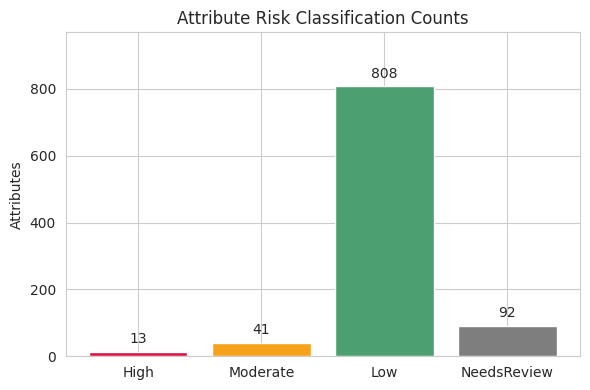

High        : 13
Moderate    : 41
Low         : 808
NeedsReview : 92
CSV summary written to: notebook_data/attribute_risk_results.csv

High risk attributes


,attribute_id,project,rationale
0,nf-osi:Author,NF-OSI,Contains direct identifiers or identity-linked...
1,el:BackgroundTrait,EL,Describes health/behavioral background traits ...
2,gf:Comment,GF,Unstructured free-text QC comment with no vali...
3,nf-osi:CompoundDose,NF-OSI,Contains clinical treatment information (dose ...
4,nf-osi:Diagnosis,NF-OSI,This attribute records an individual’s clinica...
5,mc2:FileTumorType,MC2,Contains clinical diagnosis information (tumor...
6,adkp:IndividualID,ADKP,Explicit identifying string directly linked to...
7,el:IndividualID,EL,Direct identifying string linked to the indivi...
8,htan:MSIStatus,HTAN,MSIStatus is a clinical/genomic biomarker (mic...
9,nf-osi:Nf1Genotype,NF-OSI,Contains individual genetic information (NF1 g...



Needs-review attributes


,attribute_id,project,rationale
0,el:AccessReqs,EL,Description is 'TBD' with no validation rules ...
1,el:AckContext,EL,Description is listed as TBD with no validatio...
2,el:Acknowledgment,EL,Description is listed as TBD and there are no ...
3,el:AcquistionSoftwareVersion,EL,Description is 'TBD' and there are no validati...
4,gf:AntibodyName,GF,Description is listed as 'TBD' and there are n...
...,...,...,...
87,gf:UMITag,GF,Description and valid values are listed as TBD...
88,gf:Vendor,GF,Description is 'TBD' and there are no validati...
89,htan2:Vendor,HTAN2,The attribute is described only as 'Vendor' wi...
90,gf:WhitelistCellBarcodeFileLink,GF,Description is listed as TBD and there are no ...


In [18]:

from collections import Counter
from pathlib import Path
from typing import Any, Dict, List, Optional
import csv
import json

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

RESULTS_FILE = Path("notebook_data/batch_results.jsonl")
CHART_PATH = Path("notebook_data/attribute_risk_distribution.png")
RESULTS_CSV_PATH = Path("notebook_data/attribute_risk_results.csv")
HIGH_RISK_CSV_PATH = Path("notebook_data/high_risk_attributes.csv")
NEEDS_REVIEW_CSV_PATH = Path("notebook_data/needs_review_attributes.csv")

def _coalesce_text(message: Dict[str, Any]) -> Optional[str]:
    content = message.get("content")
    if isinstance(content, str):
        return content.strip()
    if isinstance(content, list):
        parts: List[str] = []
        for item in content:
            if isinstance(item, dict):
                text = item.get("text") or item.get("content")
                if isinstance(text, str):
                    parts.append(text)
        if parts:
            return "".join(parts).strip()
    return None

def _parse_choice(choice: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    parsed = choice.get("parsed")
    if isinstance(parsed, dict):
        return parsed
    message = choice.get("message", {})
    if not isinstance(message, dict):
        return None
    parsed_message = message.get("parsed")
    if isinstance(parsed_message, dict):
        return parsed_message
    text = _coalesce_text(message)
    if not text:
        return None
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        return None

def _parse_record(record: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    response = record.get("response", {})
    if not isinstance(response, dict):
        return None
    body = response.get("body")
    choices = None
    if isinstance(body, dict):
        choices = body.get("choices")
        if not choices:
            output = body.get("output")
            if isinstance(output, dict):
                choices = output.get("choices")
    if not choices or not isinstance(choices, list):
        return None
    for choice in choices:
        if isinstance(choice, dict):
            parsed = _parse_choice(choice)
            if parsed:
                return parsed
    return None

def load_results(path: Path) -> List[Dict[str, Any]]:
    results: List[Dict[str, Any]] = []
    with path.open(encoding="utf-8") as handle:
        for line in handle:
            line = line.strip()
            if not line:
                continue
            record = json.loads(line)
            payload = _parse_record(record)
            if payload:
                results.append(payload)
    return results

def summarize(results: List[Dict[str, Any]]) -> tuple[Counter, List[Dict[str, Any]], List[Dict[str, Any]]]:
    counter: Counter = Counter()
    high_risk: List[Dict[str, Any]] = []
    needs_review: List[Dict[str, Any]] = []
    for item in results:
        risk = item.get("risk")
        if isinstance(risk, str):
            counter[risk] += 1
            if risk == "High":
                high_risk.append(item)
            elif risk == "NeedsReview":
                needs_review.append(item)
    return counter, high_risk, needs_review

def save_results_csv(results: List[Dict[str, Any]], output: Path) -> None:
    output.parent.mkdir(parents=True, exist_ok=True)
    with output.open("w", encoding="utf-8", newline="") as handle:
        writer = csv.writer(handle)
        writer.writerow(["attribute_id", "project", "risk", "rationale"])
        for item in results:
            rationale = (item.get("rationale", "") or "").replace("\n", " ")
            writer.writerow([
                item.get("attribute_id", ""),
                item.get("project", ""),
                item.get("risk", ""),
                rationale,
            ])

def render_chart(counter: Counter, output: Path) -> None:
    categories = ["High", "Moderate", "Low", "NeedsReview"]
    counts = [counter.get(cat, 0) for cat in categories]
    output.parent.mkdir(parents=True, exist_ok=True)
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(categories, counts, color=["#d14", "#f7a21b", "#4c9f70", "#7e7e7e"])
    ax.set_ylabel("Attributes")
    ax.set_title("Attribute Risk Classification Counts")
    ax.set_ylim(0, max(counts + [1]) * 1.2)
    ax.bar_label(bars, labels=[str(c) for c in counts], padding=4)
    fig.tight_layout()
    fig.savefig(output, dpi=150)
    display(fig)
    plt.close(fig)

def to_dataframe(rows: List[Dict[str, Any]]) -> pd.DataFrame:
    if not rows:
        return pd.DataFrame(columns=["attribute_id", "project", "rationale"])
    return pd.DataFrame(rows)[["attribute_id", "project", "rationale"]]

if not RESULTS_FILE.is_file():
    raise FileNotFoundError(f"Results file not found: {RESULTS_FILE}")

records = load_results(RESULTS_FILE)
if not records:
    raise SystemExit("No valid records parsed from results file.")

counts, high_risk_rows, needs_review_rows = summarize(records)

save_results_csv(records, RESULTS_CSV_PATH)
render_chart(counts, CHART_PATH)
for label in ["High", "Moderate", "Low", "NeedsReview"]:
    print(f"{label:12s}: {counts.get(label, 0)}")
print(f"CSV summary written to: {RESULTS_CSV_PATH}")

high_df = to_dataframe(high_risk_rows)
needs_review_df = to_dataframe(needs_review_rows)

high_df.to_csv(HIGH_RISK_CSV_PATH, index=False)
needs_review_df.to_csv(NEEDS_REVIEW_CSV_PATH, index=False)

print("\nHigh risk attributes")
display(high_df)
print("\nNeeds-review attributes")
display(needs_review_df)



## Discussion

### Assumptions and Limitations

This approach is more like a "static analysis", focusing on what *could* be exposed as annotations based on the data model. In practice, actual annotation exposure depends on runtime or user behavior; typically, not all attributes are required in an Annotation Template and therefore actually populated by a user.

For this analysis, we assume that Unconfigured templates are not actively used. In reality, some Unconfigured templates may be in used in specific contexts or there may be annotation activity outside fo the DCC's production standards/workflow (again, assumptions about the DCC runtime operations).

Unfortunately, we cannot account for past versions and activity. These latest data models in GitHub represent a snapshot in time. We're not looking at data management historically, where validation may have different. Also, templates may change after this analysis.


### Strengths

The benefit of this static analysis is that it is quick and analyzes all DCC data models systematically. Quantitative metrics across all projects can be generated for comparison. We identify the exact templates and attributes that produce annotations, enabling focused review of annotation-producing templates.

The analysis is data-driven and reproducible and can be re-run as data models evolve. It also highlights different approaches (conservative vs liberal) across DCCs, and provides context for understanding risk management strategies.

### Potential extensions

A more extensive/expensive review could include complementary processing of the current state of all annotation data for DCC projects currently on Synapse, making use the data warehouse. 

## For Independent Users

For users outside DCC management, there is no additional vetting for annotations; users can add any annotations they want to their private project assets, then use AI with their private projects. In this case, the user owns their data and it is up to them to understand the implications. Currently, the best approach is to add reminders and disclaimers to public docs.

## References

- [Annotating Data With Metadata - Synapse Documentation](https://help.synapse.org/docs/Annotating-Data-With-Metadata.2667708522.html)